In [1]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
# Import KNNImputer from sklearn
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



In [2]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")

In [3]:
# Display the number of missing values for each column
missing_values = d.isnull().sum()
missing_values_non_zero = missing_values[missing_values > 0]
# print("Missing values in each column (excluding zeros):\n", missing_values_non_zero)

# Imputation with KNN
imputer = KNNImputer(n_neighbors=5)
d_imputed = pd.DataFrame(imputer.fit_transform(d.select_dtypes(include='number')), columns=d.select_dtypes(include='number').columns)
# 将非数值型数据的列添加回d_imputed中
non_numeric_columns = d.select_dtypes(exclude='number').columns
d_imputed[non_numeric_columns] = d[non_numeric_columns]

# 现在d_imputed应该包含所有原始的变量了
missing_values_after_imputation = d_imputed.isnull().sum()
# print("Missing values in each column after imputation with KNN :\n ", missing_values_after_imputation)


In [4]:
# Convert dt_first_pi and dt_matr to datetime
d_imputed['dt_first_pi'] = pd.to_datetime(d_imputed['dt_first_pi'], format='%Y%m')
d_imputed['dt_matr'] = pd.to_datetime(d_imputed['dt_matr'], format='%Y%m')

# Calculate the loan term in months
d_imputed['loan_term_months'] = (d_imputed['dt_matr'].dt.year - d_imputed['dt_first_pi'].dt.year) * 12 + \
                         (d_imputed['dt_matr'].dt.month - d_imputed['dt_first_pi'].dt.month)
# print(d_imputed['loan_term_months'])


In [5]:
# Remove rows where 'cltv' is 999
removal_terms = (d_imputed['cltv'] != 999) & (d_imputed['dti'] != 999) & (d_imputed['ltv'] != 999)

d_imputed_cleaned = d_imputed[removal_terms]

In [6]:
# 综上，我们进行变量重整
# To remove the 'flag_fthb' column from your DataFrame
drop_list = ['flag_fthb','cd_msa','zipcode','prepaid','ppmt_pnlty','ltv','loan_term_months','dt_first_pi','dt_matr','id_loan']
d_imputed_cleaned_dropped = d_imputed_cleaned.drop(drop_list, axis=1)

In [7]:
# Assuming a DataFrame 'df' from the dataset you provided, we will apply One-Hot Encoding to categorical variables.

# First, let's define which columns are categorical based on the provided variable descriptions.
categorical_columns = ['channel', 'occpy_sts', 'prod_type', 'prop_type', 'loan_purpose','flag_sc']
# categorical_columns = ['channel']
# Apply One-Hot Encoding to categorical columns
d_imputed_cleaned_dropped_onehot = pd.get_dummies(d_imputed_cleaned_dropped, columns=categorical_columns)



In [8]:
def target_encode_columns(train_data, test_data, columns_to_encode = ['servicer_name', 'seller_name', 'st'], target_column = 'default'):
    """
    对指定的列进行目标编码，确保编码仅使用训练数据。
    
    参数:
    - train_data: 训练数据集的DataFrame
    - test_data: 测试数据集的DataFrame
    - columns_to_encode: 需要进行目标编码的列名列表
    - target_column: 目标变量的列名
    
    返回:
    - train_encoded: 编码后的训练数据集
    - test_encoded: 编码后的测试数据集
    """
    # 创建目标编码器实例
    encoder = TargetEncoder()
    
    # 深拷贝训练和测试数据集，避免修改原始DataFrame
    train_encoded = train_data.copy()
    test_encoded = test_data.copy()
    
    # 对每个指定列进行目标编码
    for column in columns_to_encode:
        # 使用训练数据拟合编码器
        encoder.fit(train_encoded[column], train_encoded[target_column])
        
        # 对训练和测试数据集的列进行转换
        train_encoded[column] = encoder.transform(train_encoded[column])
        test_encoded[column] = encoder.transform(test_encoded[column])
    
    return train_encoded, test_encoded

In [9]:
X = d_imputed_cleaned_dropped_onehot.drop('default', axis=1)
y = d_imputed_cleaned_dropped_onehot['default']
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=42)

In [10]:
# 需要进行目标编码的列名列表
columns_to_encode = ['servicer_name', 'seller_name', 'st']

# 将X_train和X_test合并回DataFrame形式，以便传递到自定义函数
train_data = X_train.join(y_train)
test_data = X_test

# 应用目标编码
train_encoded, test_encoded = target_encode_columns(train_data, test_data, columns_to_encode, 'default')

# 确保目标变量不在特征集中
X_train_encoded = train_encoded.drop('default', axis=1)
X_test_encoded = test_encoded
y_train_encoded = train_encoded['default']

---
## 决策树模型


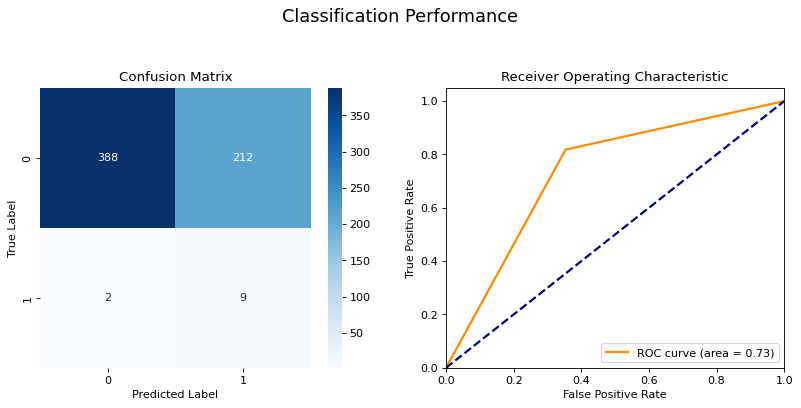

Accuracy: 0.65
Recall: 0.82
F1 Score: 0.08


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# 示例数据载入与准备
# 这里假设`X`是特征集，`y`是目标变量

# 应用undersampling
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_encoded, y_train)

# 创建决策树模型
# model = DecisionTreeClassifier(criterion = 'gini',random_state=42)
# model = DecisionTreeClassifier(criterion = 'entropy',random_state=42)
model = DecisionTreeClassifier(criterion = 'gini',random_state=42 )
model.fit(X_res, y_res)

# 进行预测
y_pred = model.predict(X_test_encoded)

# 计算各项指标
conf_matrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# ROC 曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_encoded)[:, 1])
roc_auc = auc(fpr, tpr)

# 可视化
plt.figure(figsize=(12, 10))

# Confusion Matrix
plt.subplot(221)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# ROC Curve
plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.suptitle("Classification Performance", fontsize=16)
plt.show()

# 打印指标
print(f"Accuracy: {acc:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [12]:
path = model.cost_complexity_pruning_path(X_res,y_res)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# The complexity controlling parameter
print(ccp_alphas)
# Corresponding node impurities
print(impurities)

[0.         0.00449346 0.00449346 0.0047954  0.00653595 0.00653595
 0.0070028  0.00735294 0.00746965 0.00770308 0.00784314 0.00796569
 0.00865052 0.0087146  0.00917428 0.00945378 0.0108165  0.01242311
 0.01303794 0.01742919 0.02144979 0.02240584 0.06836225 0.09259259]
[0.         0.00898693 0.01797386 0.02756465 0.04063654 0.04717249
 0.06117809 0.06853104 0.07600069 0.09140685 0.09924999 0.12314705
 0.13179757 0.14051216 0.18638356 0.19583734 0.21747033 0.24231655
 0.25535449 0.27278368 0.29423348 0.33904516 0.40740741 0.5       ]


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

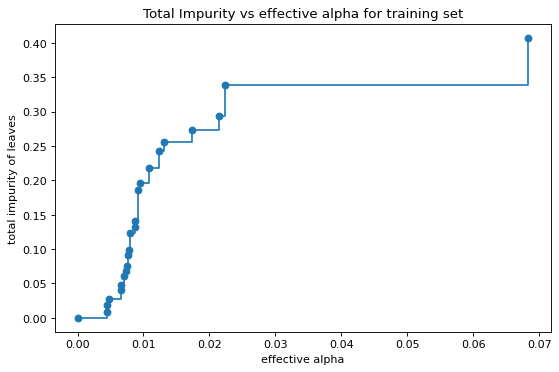

In [13]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [14]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_res, y_res)
    clfs.append(clf)
#print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#      clfs[-1].tree_.node_count, ccp_alphas[-1]))

# print(clfs)

# Score on the training based on alpha values
train_scores = [clf.score(X_res, y_res) for clf in clfs]
test_scores = [clf.score(X_test_encoded, y_test) for clf in clfs]

print(train_scores)
print(test_scores)

[1.0, 0.9901960784313726, 0.9901960784313726, 0.9852941176470589, 0.9705882352941176, 0.9705882352941176, 0.9607843137254902, 0.9558823529411765, 0.9509803921568627, 0.9313725490196079, 0.9264705882352942, 0.9117647058823529, 0.9117647058823529, 0.9019607843137255, 0.8774509803921569, 0.8676470588235294, 0.8627450980392157, 0.8431372549019608, 0.8382352941176471, 0.8284313725490197, 0.8137254901960784, 0.7598039215686274, 0.696078431372549, 0.5]
[0.6497545008183306, 0.6546644844517185, 0.6546644844517185, 0.6546644844517185, 0.662847790507365, 0.662847790507365, 0.6726677577741408, 0.6546644844517185, 0.6497545008183306, 0.6563011456628478, 0.646481178396072, 0.6595744680851063, 0.6219312602291326, 0.6104746317512275, 0.5908346972176759, 0.6366612111292962, 0.6775777414075287, 0.6121112929623568, 0.55810147299509, 0.5662847790507365, 0.6039279869067103, 0.779050736497545, 0.3993453355155483, 0.9819967266775778]


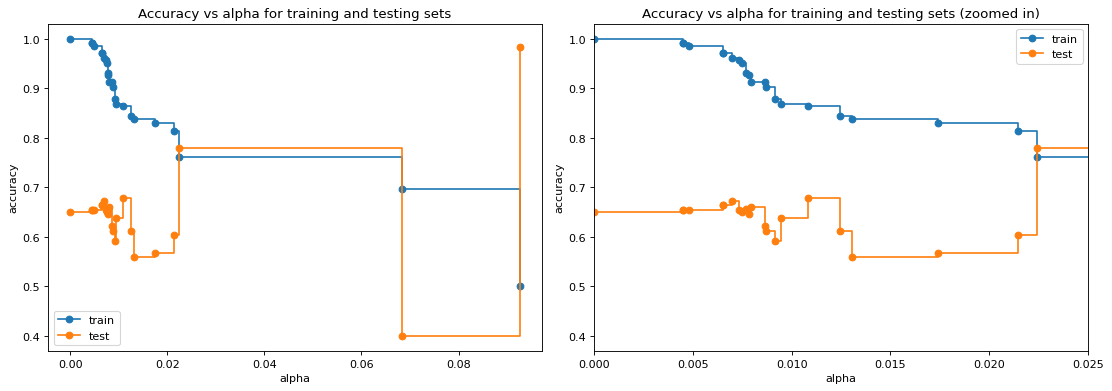

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # 1行2列的子图，设置整体图形尺寸

# 左子图
ax1.set_xlabel("alpha")
ax1.set_ylabel("accuracy")
ax1.set_title("Accuracy vs alpha for training and testing sets")
ax1.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
ax1.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
ax1.legend()

# 右子图，限制alpha的范围
ax2.set_xlabel("alpha")
ax2.set_ylabel("accuracy")
ax2.set_title("Accuracy vs alpha for training and testing sets (zoomed in)")
ax2.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
ax2.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
ax2.set_xlim(0, 0.025)  # 设置横轴的范围为0到0.008
ax2.legend()

plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.show()


这个图像显示了决策树的精度如何随着复杂度参数α的变化而变化。这里，α是决策树剪枝过程中的一个参数，用于控制树的复杂度。我们可以从图中观察到几个关键点：

1. **训练精度与α值**：随着α值的增加，训练精度总体上呈下降趋势。这是预期之内的，因为较大的α会导致更多的剪枝，这意味着模型变得更简单，对训练数据的拟合度可能会下降。

2. **测试精度与α值**：测试精度在α增加的初期波动之后，达到一个相对稳定的区域，然后再次下降。这表明在某个α值范围内，剪枝有助于模型在测试集上的泛化，但过多的剪枝（α过大）会损害模型在未见数据上的表现。

3. **训练与测试精度的差异**：在α很小时，训练和测试精度之间的差距较大，这通常是过拟合的标志。随着α的增加，这个差距缩小了，这表明剪枝有助于减少过拟合。

4. **最优α选择**：在某个点上，测试精度开始稳定，这可能表示找到了一个防止过拟合的最佳α值。然而，随后测试精度骤降，可能意味着模型过于简化，已经开始欠拟合。

### 图像的合理性分析

- **合理之处**：
  - 训练精度高于测试精度，这在大多数机器学习模型中都是常见的。
  - 随着α值的增加，模型变得更简单，精度的减少符合预期。
  - 有一个α值范围，其中测试精度相对较高且稳定，这可以用于选择模型。

- **可能的问题**：
  - 测试精度在α很小时出现大幅波动，这在实际应用中不太常见。这可能是因为数据集特别小，或者是模型评估方法有一定的随机性。
  - 在图中右侧，训练精度突然降至非常低的水平，这通常不太可能发生在实际的决策树模型中，除非这对应于一个非常极端的剪枝，几乎移除了所有决策节点。

如果这种剧烈的性能下降是在实际的模型训练过程中观察到的，这可能表明在那个特定的α值处，决策树被剪枝到只剩下一个或几个节点，这可能是不合理的剪枝行为。

### 结论

总的来说，图像中展示的训练精度和测试精度的变化趋势在大部分区域内是符合逻辑的，但在图的右侧观察到的行为需要进一步的调查，以确定是否存在数据处理、模型训练或评估过程中的问题。在实际应用中，会希望看到平滑的曲线，而不是这样的尖锐跳变。

DecisionTreeClassifier(ccp_alpha=0.0065359477124183, random_state=42)
0.8921568627450981
0.7054009819967266


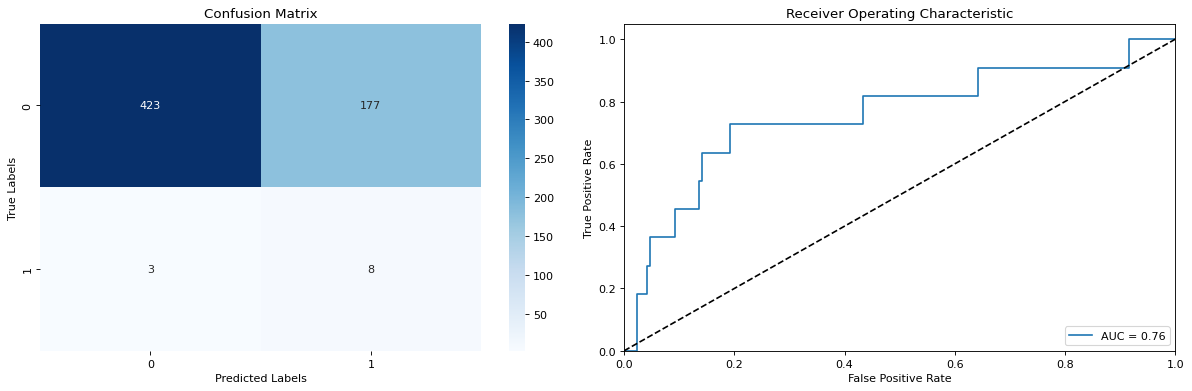

In [16]:
from sklearn.ensemble import RandomForestClassifier
# Making a rough selection over the plots
print(clfs[5])
# Then we can train a decision tree using the chosen effective alpha.
RF_ccp = RandomForestClassifier(criterion='gini',
                               random_state=42,
                               ccp_alpha = 0.015                  
                              )

RF_ccp.fit(X_res, y_res)
# Score on the training based on alpha values
train_scores = RF_ccp.score(X_res, y_res)
test_scores = RF_ccp.score(X_test_encoded, y_test)

print(train_scores)
print(test_scores)
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# 假设 RF_ccp 是已经训练好的 RandomForestClassifier 实例，以及 X_test_encoded 和 y_test 是已经准备好的测试数据和标签

# 首先进行预测
y_pred = RF_ccp.predict(X_test_encoded)
y_proba = RF_ccp.predict_proba(X_test_encoded)[:, 1]

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)

# 计算 ROC 曲线的指标
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 混淆矩阵
sns.heatmap(conf_matrix, annot=True, fmt="d", ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# ROC 曲线
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic')

# 显示图表
plt.tight_layout()
plt.show()



In [17]:
# ABOUT FEATURE IMPORTANCE IDEA 
# get the importances for the features
importances = RF_ccp.feature_importances_

importances_series = pd.Series(importances, index=list(X.columns)).sort_values(ascending = False)
importances_series.head() 

fico             0.187565
servicer_name    0.185296
seller_name      0.173561
st               0.087804
int_rt           0.080619
dtype: float64

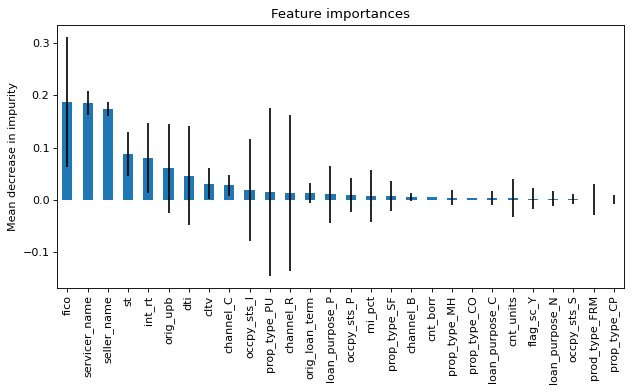

In [18]:
import time
import numpy as np

importances = RF_ccp.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_ccp.estimators_], axis=0)

fig, ax = plt.subplots()
importances_series.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

This illustration mainly shows the importance of features on the created randomforest model fit with the selected alpha value. 

- The blue bars are the feature importances of the given model, along with their inter-trees variability represented by the error bars.

- The first three important variables determined as `servicer name`, `seller name` and `fico` having value larger than 0.20 

- Comparatively, among these three variables, `occpy_sts_P` and `channel_R` have the larger inter-trees variability, denoted by thinner black lines on top of the blue bars

<Figure size 640x480 with 0 Axes>

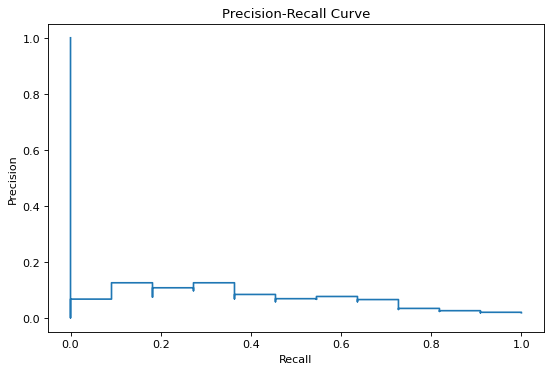

In [19]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# 假设 RF_ccp 是已经训练好的 RandomForestClassifier 实例，以及 X_test_encoded 和 y_test 是已经准备好的测试数据和标签

# 首先获得预测概率
y_proba = RF_ccp.predict_proba(X_test_encoded)[:, 1]

# 计算 Precision-Recall 曲线的值
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# 可视化 Precision-Recall 曲线
plt.figure(figsize=(8, 6))
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
